라이브러리 임포트

In [6]:
## library import - data preprocessing
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder

In [7]:
## BERT embedding 
from transformers import BertTokenizer, BertModel
import torch 

In [8]:
## Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [36]:
## 평가 지표 
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
from scipy.stats import spearmanr
from sklearn.model_selection import cross_val_score

In [10]:
## visualization
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [11]:
import matplotlib.font_manager as fm

# 한글 폰트 설정 (윈도우용)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

In [12]:
# tqdm 
from tqdm import tqdm 

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
# kaggle hub
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [37]:
import optuna
from optuna.samplers import TPESampler

In [15]:
# 파일 경로
file_path =r"C:\KHU\KHU_2025\머신러닝기초및응용_김민경교수님\Youtube_Game2_10000.csv"

# 데이터 로드
df = pd.read_csv(file_path)

In [16]:
df.head()

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_count,thumbnail_link,date,keyword
0,C6PrhsZ4dLI,Play Game#Kritikachannel#Shorts funny video,Kritika Channel,22,[none],1261217614,16207795,0,0,https://i.ytimg.com/vi/C6PrhsZ4dLI/default.jpg,29.10,game
1,0e3GPea1Tyg,"$456,000 Squid Game In Real Life!",MrBeast,24,[none],804577951,19234279,0,628015,https://i.ytimg.com/vi/0e3GPea1Tyg/default.jpg,24.11,game
2,jBOyUo3JaiA,Vlad and story about Worms from the game,Vlad and Niki,24,Vlad|for kids|vlad and nikita|toys|playing|gam...,562644972,1652861,0,0,https://i.ytimg.com/vi/jBOyUo3JaiA/default.jpg,24.05,game
3,yGKhcLK482Y,Squid Game Dalgona #shorts,Mr DegrEE,22,shorts|squid game|funny|mr degree|mariana|mari...,471345780,2619112,0,2969,https://i.ytimg.com/vi/yGKhcLK482Y/default.jpg,22.05,game
4,iBh3zOjOCvI,Jelly Bean Guessing Game HACK,Mark Rober,28,[none],240356873,6154177,0,20292,https://i.ytimg.com/vi/iBh3zOjOCvI/default.jpg,30.04,game


In [17]:
# 데이터 확인 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13906 entries, 0 to 13905
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   video_id        13906 non-null  object 
 1   title           13906 non-null  object 
 2   channel_title   13906 non-null  object 
 3   category_id     13906 non-null  int64  
 4   tags            13906 non-null  object 
 5   views           13906 non-null  int64  
 6   likes           13906 non-null  int64  
 7   dislikes        13906 non-null  int64  
 8   comment_count   13906 non-null  int64  
 9   thumbnail_link  13906 non-null  object 
 10  date            13906 non-null  float64
 11  keyword         13906 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.3+ MB


In [18]:
# 필요한 칼럼만 추출
df = df[['title', 'views']].copy()

Text(0, 0.5, 'Frequency')

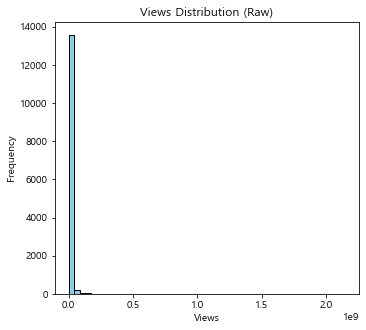

In [19]:
# 원본 분포
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['views'], bins=50, color='skyblue', edgecolor='black')
plt.title('Views Distribution (Raw)')
plt.xlabel('Views')
plt.ylabel('Frequency')

In [20]:
# target scaling
df['log_views'] = np.log1p(df['views'])

# scaler = StandardScaler()
# df['scaled_views'] = scaler.fit_transform(df[['log_views']])

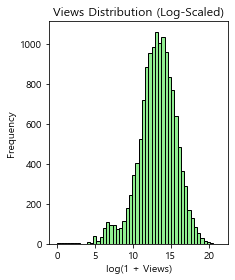

In [21]:
# 로그 변환 분포
plt.subplot(1, 2, 2)
plt.hist(df['log_views'], bins=50, color='lightgreen', edgecolor='black')
plt.title('Views Distribution (Log-Scaled)')
plt.xlabel('log(1 + Views)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [22]:
# BERT load 
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [23]:
# BERT embedding extract 
## CLS 벡터 추출 함수 정의 
def extract_cls_embedding(text):
    encoding = tokenizer(text,
                         max_length=32,
                         truncation=True,
                         padding='max_length',
                         return_tensors='pt')
    input_ids_tensor = encoding['input_ids'].to(device)
    attention_mask_tensor = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return cls_embedding

In [24]:
## 제목을 cls로 추출 
embeddings = np.array([
    extract_cls_embedding(title) for title in tqdm(df['title'])
])

100%|████████████████████████████████████████████████████████████████████████████| 13906/13906 [40:56<00:00,  5.66it/s]


In [25]:
X = embeddings
y = df['log_views']

# test, train dataset 분리 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [26]:
# Model 성능 평가 함수 
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    spearman_corr, _ = spearmanr(y_test, y_pred)

    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Spearman: {spearman_corr:.4f}")
    
    return model, rmse, r2, spearman_corr

Lasso(베이지안 최적화)

In [38]:
def objective_lasso(trial):
    alpha = trial.suggest_float('alpha', 1e-3, 1.0, log=True) #범위 축소
    model = Lasso(alpha=alpha, random_state=42, max_iter=10000)
    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=3, error_score=np.nan)
    return -score.mean()

study_lasso = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study_lasso.optimize(objective_lasso, n_trials=1)

# 튜닝된 모델로 최종 학습 및 평가
best_alpha = study_lasso.best_params['alpha']
lasso_best = Lasso(alpha=best_alpha, random_state=42, max_iter=10000)
lasso_best.fit(X_train, y_train)
y_pred = lasso_best.predict(X_test)

# 성능 지표 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
spearman_corr = spearmanr(y_test, y_pred).correlation if np.std(y_pred) > 0 else np.nan

# 출력
print("Model: Lasso (Bayesian)")
print("Best Alpha:", best_alpha)
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))
print("Spearman:", "NaN" if np.isnan(spearman_corr) else round(spearman_corr, 4))

# 결과 저장
lasso_optuna_df = pd.DataFrame([{
    "Model": "Lasso (Bayesian)",
    "Alpha": best_alpha,
    "RMSE": rmse,
    "R²": r2,
    "Spearman": spearman_corr
}])

#결과 csv로 저장
lasso_optuna_df.to_csv("lasso_optuna_result(game_Bayesian).csv", index=False)

[I 2025-06-12 12:11:25,970] A new study created in memory with name: no-name-821f8927-6959-48d4-b5ba-9b3dc90ae652
[I 2025-06-12 12:11:27,543] Trial 0 finished with value: 4.618359739583611 and parameters: {'alpha': 0.013292918943162165}. Best is trial 0 with value: 4.618359739583611.


Model: Lasso (Bayesian)
Best Alpha: 0.013292918943162165
RMSE: 2.1188
R²: 0.246
Spearman: 0.4799


Linear Regression

In [28]:
# LinearRegression 모델 정의 및 학습
linear = LinearRegression()
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)

# 성능 지표 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
spearman_corr = spearmanr(y_test, y_pred).correlation if np.std(y_pred) > 0 else np.nan

# 출력
print("Model: LinearRegression")
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))
print("Spearman:", "NaN" if np.isnan(spearman_corr) else round(spearman_corr, 4))

# 결과 저장
linear_results_df = pd.DataFrame([{
    "Model": "LinearRegression",
    "Alpha": None,
    "RMSE": rmse,
    "R²": r2,
    "Spearman": spearman_corr
}])

#결과 csv로 저장
linear_results_df.to_csv("linear_regression_result.csv", index=False)

Model: LinearRegression
RMSE: 2.0063
R²: 0.324
Spearman: 0.5297


Ridge(베이지안 최적화)

In [39]:
def objective_ridge(trial):
    alpha = trial.suggest_float('alpha', 1e-3, 1.0, log=True)
    model = Ridge(alpha=alpha, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=3, error_score=np.nan)
    return -score.mean()

study_ridge = optuna.create_study(direction='minimize',sampler=TPESampler(seed=42))
study_ridge.optimize(objective_ridge, n_trials=1)

# 튜닝된 모델로 최종 학습 및 평가
best_alpha = study_ridge.best_params['alpha']
ridge_best = Ridge(alpha=best_alpha, random_state=42)
ridge_best.fit(X_train, y_train)
y_pred = ridge_best.predict(X_test)

# 성능 지표 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
spearman_corr = spearmanr(y_test, y_pred).correlation if np.std(y_pred) > 0 else np.nan

#출력
print("Model: Ridge (Bayesian)")
print("Alpha:", best_alpha)
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))
print("Spearman:", round(spearman_corr, 4) if not np.isnan(spearman_corr) else "NaN")

#결과 저장
ridge_optuna_df = pd.DataFrame([{
    "Model": "Ridge (Bayesian)",
    "Alpha": best_alpha,
    "RMSE": rmse,
    "R²": r2,
    "Spearman": spearman_corr
}])

#결과 csv로 저장
ridge_optuna_df.to_csv("ridge_optuna_result(game_Bayesian).csv", index=False)

[I 2025-06-12 12:11:56,898] A new study created in memory with name: no-name-368ea120-8c31-46ea-be19-9b5093e6472c
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.76886e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.76813e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.77316e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
[I 2025-06-12 12:11:57,325] Trial 0 finished with value: 4.213512283728379 and parameters: {'alpha': 0.013292918943162165}. Best is trial 0 wi

Model: Ridge (Bayesian)
Alpha: 0.013292918943162165
RMSE: 2.0062
R²: 0.324
Spearman: 0.5297


RF(베이지안 최적화)

In [40]:
def objective_rf(trial):
    model = RandomForestRegressor(
        n_estimators=trial.suggest_int('n_estimators', 50, 150),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 6),
        max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        random_state=42,
        n_jobs=-1
    )
    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=3, error_score=np.nan, n_jobs=-1)
    return -score.mean()

study_rf = optuna.create_study(direction='minimize',sampler=TPESampler(seed=42))
study_rf.optimize(objective_rf, n_trials=1, show_progress_bar=True)

# 튜닝된 모델로 최종 학습 및 평가
best_params_rf = study_rf.best_params
rf_best = RandomForestRegressor(**best_params_rf, random_state=42, n_jobs=-1)
rf_best.fit(X_train, y_train)
y_pred = rf_best.predict(X_test)

# 성능 지표 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
spearman_corr = spearmanr(y_test, y_pred).correlation if np.std(y_pred) > 0 else np.nan

# 출력
print("Model: RandomForest (Bayesian)")
print("Params:", best_params_rf)
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))
print("Spearman:", round(spearman_corr, 4) if not np.isnan(spearman_corr) else "NaN")

# 결과 저장
rf_optuna_df = pd.DataFrame([{
    "Model": "RandomForest (Bayesian)",
    "Alpha": None,
    "RMSE": rmse,
    "R²": r2,
    "Spearman": spearman_corr
}])

#결과 csv로 저장
rf_optuna_df.to_csv("rf_optuna_result(game_Bayesian).csv", index=False)

[I 2025-06-12 12:12:13,569] A new study created in memory with name: no-name-f2850859-d80f-452c-a5db-fca8be622f1c


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-12 12:12:27,061] Trial 0 finished with value: 4.4618421523696945 and parameters: {'n_estimators': 87, 'max_depth': 10, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 4.4618421523696945.
Model: RandomForest (Bayesian)
Params: {'n_estimators': 87, 'max_depth': 10, 'min_samples_split': 5, 'max_features': 'sqrt'}
RMSE: 2.0639
R²: 0.2846
Spearman: 0.5455


Gradient(베이지안 최적화)

In [49]:
def objective_gbr(trial):
    model = GradientBoostingRegressor(
        n_estimators=trial.suggest_int('n_estimators', 50, 150),
        learning_rate=trial.suggest_float('learning_rate', 0.05,0.2),
        max_depth=trial.suggest_int('max_depth', 3, 6),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 6),
        subsample=trial.suggest_float('subsample', 0.7, 1.0),
        random_state=42
    )
    score = cross_val_score(
        model, X_train, y_train,
        scoring='neg_mean_squared_error',
        cv=2,
        error_score=np.nan  # ✅ 이거 하나가 핵심!
    )
    return -np.nanmean(score)  # 모든 trial 실패 시에도 안전하게 작동

study_gbr = optuna.create_study(direction='minimize')

from tqdm.notebook import tqdm
for _ in tqdm(range(30), desc="Gradient Boosting 튜닝 중"):
    study_gbr.optimize(objective_gbr, n_trials=1)

# 튜닝된 모델로 최종 학습 및 평가
best_params_gbr = study_gbr.best_params
gbr_best = GradientBoostingRegressor(**best_params_gbr, random_state=42)
gbr_best.fit(X_train, y_train)
y_pred = gbr_best.predict(X_test)

# 성능 지표 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
spearman_corr = spearmanr(y_test, y_pred).correlation if np.std(y_pred) > 0 else np.nan

# 출력
print("Model: GradientBoosting (Bayesian)")
print("Params:", best_params_gbr)
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))
print("Spearman:", round(spearman_corr, 4) if not np.isnan(spearman_corr) else "NaN")

# 결과 저장
gbr_optuna_df = pd.DataFrame([{
    "Model": "GradientBoosting (Bayesian)",
    "Alpha": None,
    "RMSE": rmse,
    "R²": r2,
    "Spearman": spearman_corr
}])

#결과 csv로 저장
gbr_optuna_df.to_csv("gbr_optuna_result.csv", index=False)

[I 2025-06-12 01:14:56,305] A new study created in memory with name: no-name-2bc6170a-76df-4c59-86ab-27f075bdd2c2


Gradient Boosting 튜닝 중:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-06-12 01:23:41,472] Trial 0 finished with value: 3.921426807265728 and parameters: {'n_estimators': 114, 'learning_rate': 0.10122873434404372, 'max_depth': 6, 'min_samples_split': 2, 'subsample': 0.7510055172076476}. Best is trial 0 with value: 3.921426807265728.
[I 2025-06-12 01:29:10,802] Trial 1 finished with value: 4.090084530042812 and parameters: {'n_estimators': 57, 'learning_rate': 0.15887993660159377, 'max_depth': 6, 'min_samples_split': 4, 'subsample': 0.9291615644116062}. Best is trial 0 with value: 3.921426807265728.
[I 2025-06-12 01:37:00,894] Trial 2 finished with value: 3.9893422758016595 and parameters: {'n_estimators': 85, 'learning_rate': 0.06219291201821538, 'max_depth': 6, 'min_samples_split': 4, 'subsample': 0.9145653476270623}. Best is trial 0 with value: 3.921426807265728.
[I 2025-06-12 01:48:07,577] Trial 3 finished with value: 3.9488156084667345 and parameters: {'n_estimators': 129, 'learning_rate': 0.1433789058991277, 'max_depth': 5, 'min_samples_split

Model: GradientBoosting (Bayesian)
Params: {'n_estimators': 137, 'learning_rate': 0.07704946988735725, 'max_depth': 6, 'min_samples_split': 5, 'subsample': 0.7473783788928473}
RMSE: 1.9129
R²: 0.3854
Spearman: 0.5737


In [41]:
#gbr 저장한 거 불러오기
gbr_saved_df = pd.read_csv("gbr_optuna_result.csv")

# 모델별 결과 DataFrame 합치기
all_results = pd.concat([
    lasso_optuna_df,
    linear_results_df,
    ridge_optuna_df,
    rf_optuna_df,
    gbr_saved_df
], ignore_index=True)


#결과 csv로 저장
all_results.to_csv("game_all_results(Bayesian).csv", index=False)

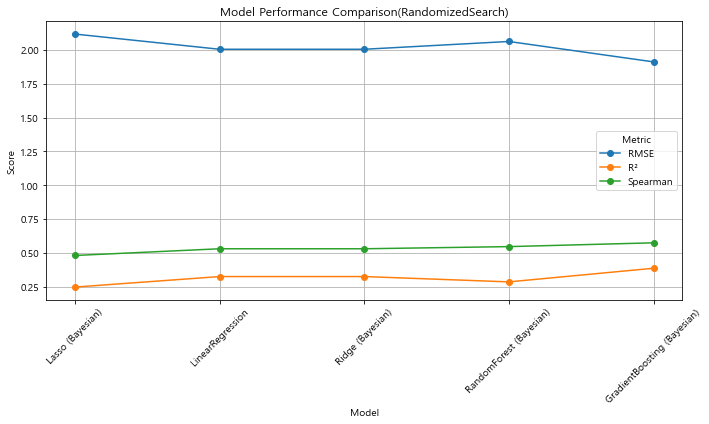

In [42]:
#시각화를 위한 변환 (wide → long)
results_long = all_results.melt(
    id_vars="Model", 
    value_vars=["RMSE", "R²", "Spearman"],
    var_name="Metric", 
    value_name="Score"
)

# 선 그래프(line chart)로 시각화
plt.figure(figsize=(10, 6))
for metric in results_long["Metric"].unique():
    subset = results_long[results_long["Metric"] == metric]
    plt.plot(subset["Model"], subset["Score"], marker='o', label=metric)

plt.title("Model Performance Comparison(RandomizedSearch)")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
game_all_results_Bayesian_saved_df = pd.read_csv("game_all_results(Bayesian).csv")

In [45]:
game_all_results_Bayesian_saved_df

,Model,Alpha,RMSE,R²,Spearman
0,Lasso (Bayesian),0.013293,2.118844,0.245976,0.479949
1,LinearRegression,NaN,2.006280,0.323964,0.529674
2,Ridge (Bayesian),0.013293,2.006245,0.323987,0.529678
3,RandomForest (Bayesian),NaN,2.063883,0.284586,0.545548
4,GradientBoosting (Bayesian),NaN,1.912871,0.385448,0.573715
